### Intro

I performed competition of different methods for binary classification. Methods were selected to cover different families of ML models. Preliminary result of the expected performance can be seen at https://archive.ics.uci.edu/dataset/45/heart+disease > "Baseline Model Performance"

Ranking metric: F1 score

Model Competition: 

1. **Logistic Regression**:
   - Description: Logistic Regression is a linear model that is commonly used for binary classification tasks. It models the probability of a binary outcome using the logistic function.

2. **XGBoost (Extreme Gradient Boosting)**:
   - Description: XGBoost is a gradient boosting framework known for its high performance and accuracy in classification tasks. It is an ensemble learning method that combines multiple decision trees.

3. **LightGBM (Light Gradient Boosting Machine)**:
   - Description: LightGBM is another gradient boosting framework that is highly efficient and handles large datasets with ease. It uses a histogram-based approach to improve training speed.

4. **Neural Network**:
   - Description: A neural network-based model, such as a deep feedforward neural network or a convolutional neural network, can capture complex patterns in data for classification tasks. It is highly versatile and can be adapted for various tasks.

5. **Random Forest**:
   - Description: Random Forest is an ensemble learning method that combines multiple decision trees to improve classification accuracy. It is robust, handles overfitting well, and can capture complex relationships in the data.

6. **Support Vector Machine (SVM)**:
   - Description: Support Vector Machines are powerful classifiers that aim to find the optimal hyperplane to separate different classes in the data. They are effective for both linear and nonlinear classification tasks.

7. **K-Nearest Neighbors**:
   - Description: K-Nearest Neighbors is a simple and effective classification algorithm that classifies data points based on the majority class among their k-nearest neighbors in the feature space.

8. **Naive Bayes**:
   - Description: Naive Bayes is a probabilistic classification algorithm based on Bayes' theorem. It assumes that features are conditionally independent, making it computationally efficient and effective for text classification tasks.

9. **Decision Tree**:
   - Description: Decision Trees are a non-parametric classification algorithm that splits the data into different classes by making decisions based on features at each node of the tree. They are interpretable and can model complex decision boundaries.

10. **AdaBoost (Adaptive Boosting)**:
    - Description: AdaBoost is an ensemble learning method that combines multiple weak classifiers to create a strong classifier. It focuses on misclassified instances in each iteration, improving classification accuracy.


In [15]:
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [16]:
# Load Dataset
df = pd.read_csv("../Data/uci_heart_disease.processed.tsv", sep="\t")

In [17]:
# Set random Seed
np.random.seed(123)

In [18]:
# Define relevant features
# fmt:off
numeric_features = ["age", "trestbps", "thalach", "oldpeak", "slope"]
binary_features = ["sex", "cp_1", "cp_2", "cp_3", "restecg_1", "restecg_2", "exang"]
features = numeric_features + binary_features
# fmt:on
target = "num"

In [19]:
# Split Train and test datasets
X = df[features]
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [20]:
# Compute the positive weight to balance the sample
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

In [21]:
# Set the list of models to compete
models = {
    "Logistic Reg.": LogisticRegression(class_weight="balanced"),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "SVM": SVC(class_weight="balanced"),
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(),
}

In [22]:
# General preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_features),
        ("cat", "passthrough", binary_features),
    ]
)

In [23]:
# Create pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    pipelines[model_name] = pipeline

scoring = {
    "acc": "accuracy",
    "f1": "f1_weighted",
    "recall": "recall_weighted",
    "precision": "precision_weighted",
}

scores = {}
# Perform cross-validation and compare F1 scores
for model_name, pipeline in pipelines.items():
    scores[model_name] = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        fit_params=(
            {"classifier__sample_weight": classes_weights}
            if model_name == "XGBoost"
            else None
        ),
    )
    f1_scores = scores[model_name]["test_f1"]
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)

c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [24]:
# Format the scoring so it can be plotted
# fmt:off
metrics = pd.DataFrame([], columns=[ "fit_time", "score_time", "test_acc", "test_f1",
                                    "test_recall", "test_precision", "model_name"])

# fmt:on

for model_name in scores.keys():
    tmp = pd.DataFrame(scores[model_name])
    tmp["model_name"] = model_name

    metrics = pd.concat([metrics, tmp])

### Model competition results

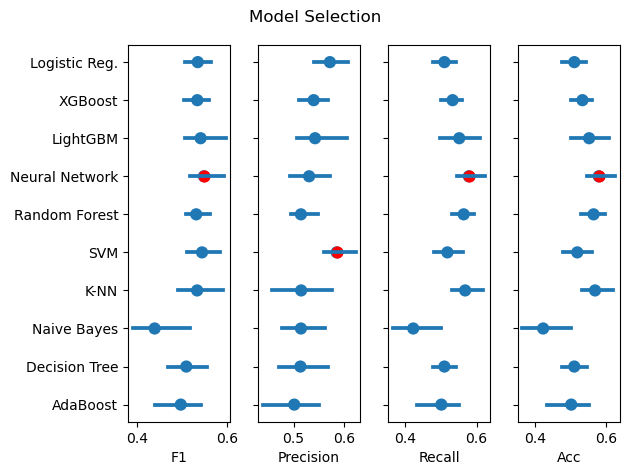

In [25]:
# Plot competition results

fig, ax = plt.subplots(1, 4, sharey=True)

for (i, metric), ylabel in zip(
    enumerate(["test_f1", "test_precision", "test_recall", "test_acc"]),
    ["F1", "Precision", "Recall", "Acc"],
):
    sns.pointplot(data=metrics, x=metric, y="model_name", join=False, ax=ax[i])
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(ylabel)
    # ax[i].set_xlim([0.65, 0.95])

    ranking = metrics.groupby("model_name")[metric].mean().sort_values(ascending=False)

    ax[i].scatter(
        ranking.values[0],
        list(models).index(ranking.index[0]),
        color="r",
        marker="o",
        s=60,
    )

fig.suptitle("Model Selection")
plt.tight_layout()
fig.savefig("../Figures/45.multiclass_classifier_model_selection.png")

In [26]:
f1_ranking = (
    metrics.groupby("model_name").mean().sort_values(by="test_f1", ascending=False)
)
f1_winner = f1_ranking.index[0]

f1_ranking

,fit_time,score_time,test_acc,test_f1,test_recall,test_precision
model_name,,,,,,
Neural Network,0.262711,0.003382,0.578501,0.548213,0.578501,0.530751
SVM,0.006040,0.009348,0.518686,0.544003,0.518686,0.585683
LightGBM,0.162728,0.010668,0.551654,0.540860,0.551654,0.542578
Logistic Reg.,0.008425,0.005260,0.510374,0.534511,0.510374,0.572064
XGBoost,0.183892,0.010581,0.533097,0.533529,0.533097,0.539824
K-NN,0.006247,0.003106,0.568149,0.533148,0.568149,0.514909
Random Forest,0.121166,0.009525,0.564068,0.531051,0.564068,0.514470
Decision Tree,0.002999,0.007843,0.510288,0.509037,0.510288,0.513420
AdaBoost,0.057762,0.007698,0.501804,0.496764,0.501804,0.501128


In [27]:
pipelines[f1_winner].fit(X_train, y_train)
y_pred = pipelines[f1_winner].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.90      0.80       108
         1.0       0.19      0.18      0.19        38
         2.0       0.27      0.12      0.16        26
         3.0       0.42      0.38      0.40        26
         4.0       0.00      0.00      0.00        10

    accuracy                           0.56       208
   macro avg       0.32      0.32      0.31       208
weighted avg       0.49      0.56      0.52       208



c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Hyper-parameter Tunning

In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid for grid search
param_grid = {
    "SVM": {
        "classifier__C": [0.1, 1, 10],  # Regularization parameter
        "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel function
        # Degree of the polynomial kernel (if 'poly' kernel is selected)
        "classifier__degree": [2, 3, 4],
        # Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels
        "classifier__gamma": ["scale", "auto", 0.1, 1, 10],
    },
    "Neural Network": {
        "classifier__hidden_layer_sizes": [
            (100,),
            (50, 50),
            (100, 50, 25),
        ],  # Vary the number of neurons in each hidden layer
        "classifier__alpha": [0.0001, 0.001, 0.01],  # L2 regularization parameter
        "classifier__max_iter": [200, 400, 600],  # Maximum number of iterations
    },
}

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(
    estimator=pipelines[f1_winner],
    param_grid=param_grid[f1_winner],
    scoring="f1_weighted",
    cv=cv,
)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

In [29]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.94      0.80       108
         1.0       0.23      0.18      0.21        38
         2.0       0.15      0.08      0.10        26
         3.0       0.43      0.35      0.38        26
         4.0       0.00      0.00      0.00        10

    accuracy                           0.57       208
   macro avg       0.30      0.31      0.30       208
weighted avg       0.48      0.57      0.52       208



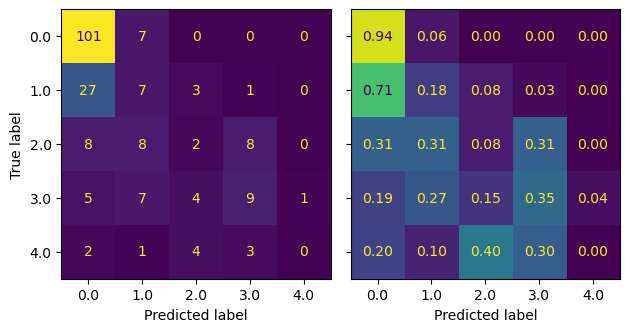

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, sharey=True)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax[1],
    im_kw={"vmin": 0, "vmax": 1},
    colorbar=False,
)
ax[1].set_ylabel(None)
plt.tight_layout()
plt.savefig("../Figures/40.multiclass_confusion_matrix.png")

### Save trained best model

In [31]:
import joblib

model_filename = "../Models/best_multiclass_classifier.pkl"
joblib.dump(grid_search.best_estimator_, model_filename)

['../Models/best_multiclass_classifier.pkl']

### Model explainability

In [32]:
import shap

best_binary_model = grid_search.best_estimator_["classifier"].predict
preprocessor = grid_search.best_estimator_["preprocessor"]

X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test), columns=X.columns)

explainer = shap.Explainer(best_binary_model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


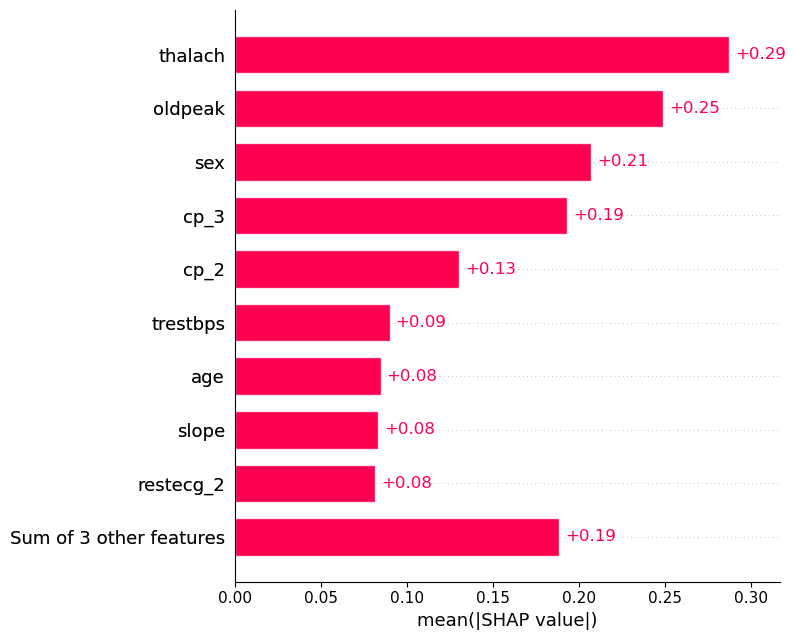

In [33]:
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig("../Figures/45.multiclass_classifier_shap_values.png")